## Prediction model

Main purpose of this model:
Predict whether a player will perform above or below their expected xG/xA/Defensive actions/goals prevented

| Role        | Better Target                                               |
|-------------|-------------------------------------------------------------|
| Forwards    | Over/under xG (finishing efficiency)                        |
| Midfielders | xA vs Assists (creative efficiency)                         |
| Defenders   | Defensive actions per 90/ duel success rate                 |
| Goalkeepers | Goals prevented vs. expected (post-shot xG - goals conceded |


⚙️ 1. Define role-specific “performance targets”

We’ll use one main efficiency metric per role:

| Role                                    | Target Definition                                         | Meaning                                     |
|-----------------------------------------|-----------------------------------------------------------|---------------------------------------------|
| Forwards (FW)                           | goals_per90 / xg_per90                                    | finishing efficiency — > 1 = overperforming |
| Attacking / Central Midfielders (MF/AM) | assists_per90 / xag_per90                                 | creative efficiency — > 1 = outperforming expected assists |
| Defenders (DF)                          | tackles_won + interceptions + clearances per 90           | defensive activity (normalized)             |
| Goalkeepers (GK)                        | expected_goals_on_target_conceded – goals_conceded per 90 | shot-stopping efficiency — positive = saving more than expected |


Regression Model

Why did we pick a regression model? Regression models predict continuous values, we are trying to predict how a player will perform on the epl based on their euro performance.

# Step 1: Imports

In [54]:
!pip install matplotlib


  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 137.8 kB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 115.5 kB/s eta 0:00:0000:0100:02
Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl (270 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 544.0 kB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl (65 kB)

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 1.7 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.6 MB/s eta 0:00:00a 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.4 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 2.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.9 MB/s eta 0:00:00a 0:00:01


In [82]:
import torch
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from soccerdata import FBref
import unicodedata
from unidecode import unidecode

# Step 2: Data Preparation

1.	load your Euro parquet → 2) clean & engineer features/targets in pandas → 3) split data → 4) (optionally) scale/encode → 5) convert to tensors → 6) wrap in a Dataset/DataLoader.

In [20]:
print(Path.cwd())

current_dir = Path.cwd()
parent_dir = current_dir.parent

sub_folder = os.path.join(parent_dir, "data")
tgt_subfolder = os.path.join(sub_folder, "tournaments")
tgt_parent_subfolder = os.path.join(tgt_subfolder, "outputs_euro")
target = os.path.join(tgt_parent_subfolder, "processed", 'player_agg_euro_2024.parquet')

DATA = target

if os.path.exists(DATA):
    print(f"The path '{DATA}' exists.")
else:
    print(f"The path '{DATA}' does not exist.")

/Users/derrick/DataspellProjects/epl/epl-predictor/backend/models
The path '/Users/derrick/DataspellProjects/epl/epl-predictor/backend/data/tournaments/outputs_euro/processed/player_agg_euro_2024.parquet' exists.


In [21]:
# Load the data from the outputs_euro

df = pd.read_parquet(DATA)

df = df[df['minutes'].fillna(0) > 0].copy()

# get the roles for the players
def to_role(p):
    if isinstance(p, str):
        p = p.split(",")[0].strip()
    if p in ("GK",):                     return "GK"
    if p in ("DF","FB","WB","CB"):       return "DF"
    if p in ("MF","DM","CM","AM","WM"):  return "MF"
    if p in ("FW","CF","WF","SS"):       return "FW"
    return 'UNK'

df['role'] = df['primary_pos'].apply(to_role)
df = df[df["role"] != "UNK"].copy()


In this section, we define the target tasks, meaning we break down the most suitable metrics to use
* There is a lot of bias when using xg as defenders and goalkeepers tend to have a low xg, so divide the targets into 2
* Forwards: we use the gls per 90 (goals scored per game) vs xg per 90(expected goals per game)
* Midfielders/defenders/goalkeepers: We use starter rate: typically means how many games they start, why:
1.         Consistency & trust
2.         Coaches repeatedly starting a player indicates reliability, fitness, and tactical importance.
3.         Cross-positional availability
4.         Every player has this stat — from goalkeepers to forwards. It allows comparing “usage” levels within a team or role.
5.         Indirect performance signal

Later on, we will add richer stats for the defenders and midfielders (tackles, clearances, passes completed, saves)

In [26]:
# --- Helpers ---
def zscore(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    mu = s.mean()
    sd = s.std(ddof=0)
    if pd.isna(sd) or sd == 0:
        return pd.Series(0.0, index=s.index, dtype="Float64")
    out = (s - mu) / sd
    return out.astype("Float64")

# Ensure role exists (map from your 'primary_pos'); adjust if you already built 'role'
if "role" not in df.columns:
    pos = df["primary_pos"].fillna("")
    df["role"] = (
        np.select(
            [
                pos.str.startswith(("FW","ST","CF","LW","RW")),
                pos.str.startswith(("MF","CM","DM","AM","LM","RM")),
                pos.str.startswith(("DF","CB","RB","LB","RWB","LWB")),
                pos.str.startswith(("GK",)),
            ],
            ["FW","MID","DEF","GK"],
            default="MID",
        )
        .astype("string")
    )

# Make sure source columns are numeric
for c in ["gls_90","xg_90","starter_rate"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- Build targets with explicit nullable dtypes ---
is_fw = df["role"].eq("FW").fillna(False)

# target_cls: Int8 (nullable)
df["target_cls"] = pd.Series(pd.NA, index=df.index, dtype="Int8")
# Forwards: goals per 90 > xG per 90
comp_fw = (df.loc[is_fw, "gls_90"] > df.loc[is_fw, "xg_90"]).astype("Int8")
df.loc[is_fw, "target_cls"] = comp_fw

# Non-forwards: starter_rate >= median within non-FW
non_fw = ~is_fw
thr = df.loc[non_fw, "starter_rate"].median(skipna=True)
df.loc[non_fw, "target_cls"] = (df.loc[non_fw, "starter_rate"] >= thr).astype("Int8")

# target_reg: Float64 (nullable)
df["target_reg"] = pd.Series(pd.NA, index=df.index, dtype="Float64")

# Forwards: z-score of (gls_90 - xg_90)
df["delta_fw"] = (df["gls_90"] - df["xg_90"]).astype("Float64")
df.loc[is_fw, "target_reg"] = zscore(df.loc[is_fw, "delta_fw"]).astype("Float64")

# Others: z-score of starter_rate within each role (DEF/MID/GK separately)
df["delta_other"] = df["starter_rate"].astype("Float64")
df.loc[non_fw, "target_reg"] = (
    df.loc[non_fw]
      .groupby("role", group_keys=False)["delta_other"]
      .apply(zscore)
      .astype("Float64")
)

# Final modeling frame
df_model = (
    df.replace([np.inf, -np.inf], np.nan)
      .dropna(subset=["target_cls", "target_reg"])
      .copy()
)

**Features**:

Here we define the features that we will use to train the model, as for now we use the features with the least leakage, we will expand later on...


In [45]:
num_feats = [
    "age","minutes","nineties","mp","starts",
    "minutes_share","starter_rate",
    "xg_90","xag_90","npxg_90","npxg_xag_90",
    # light totals (scaled by 90s anyway, but fine to include)
    "gls_90","ast_90","ga_90",
]

cat_feats = ['role']
# Hot encode the features
df_model = df_model.replace([np.inf, -np.inf], np.nan).copy()
y = df_model["target_reg"]
mask = y.notna()
y = y.loc[mask]
X = df_model.loc[mask, num_feats + cat_feats]

# the target variables for training
y = df_model["target_reg"].astype(float)

# Step 3: Train/test split

As for the data we split it into three parts:
1. train: 70%, to fit the model
2. validation: 15%,, to monitor during training
3. test: 15%, for final evaluation

What are we aiming for or what is our target?
Our target for the model is: Given a player’s minutes, xG, assists, role, etc., predict how far above or below expectation they perform

Then we will use this prediction to:

* Rank all players.
* Cluster similar performers.
* Identify consistent overperformers across tournaments.

In [47]:
# train split
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_model.loc[X.index, "role"]
)

# validation split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=df_model.loc[X_temp.index, "role"]
)


# Step 4: Model definition and preprocessing

	1.	Use Ridge to find stable feature importances.
	2.	Use Random Forest to rank players and make performance predictions.
	3.	Compare both — if they agree, your model’s probably capturing real signal.

In [50]:
# keep only numeric columns that have at least one observed value
valid_num = [c for c in num_feats if X[c].notna().any()]
dropped = sorted(set(num_feats) - set(valid_num))
if dropped:
    print("Dropping all-NaN numeric features:", dropped)

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

pre = ColumnTransformer([
    ("num", num_pipe, valid_num),
    ("cat", cat_pipe, cat_feats),
])


models = {
    "linreg": LinearRegression(),
    "ridge": RidgeCV(alphas=np.logspace(-4, 4, 25), cv=5),
    "rf": RandomForestRegressor(
        n_estimators=600, max_depth=None, min_samples_leaf=2, random_state=42, n_jobs=-1
    ),
}

pipes =  { name: Pipeline([("pre", pre), ("model", m)]) for name, m in models.items() }

Dropping all-NaN numeric features: ['ga_90']


# Step 5: Train and validate the model

In [52]:
def eval_reg(y_true, y_pred, label=''):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label:>8} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    return {"mae": mae, "rmse": rmse, "r2": r2}

scores = {}
for name, pipe in pipes.items():
    # train the model
    pipe.fit(X_train, y_train)
    pred_val = pipe.predict(X_val)
    scores[name] = eval_reg(y_val, pred_val)

best_name = min(scores, key=lambda k: scores[k]["rmse"])
best_pipe = pipes[best_name]
print(f"\nBest on VAL: {best_name} → {scores[best_name]}")

         | MAE: 0.356 | RMSE: 0.239 | R2: 0.592
         | MAE: 0.358 | RMSE: 0.225 | R2: 0.615
         | MAE: 0.084 | RMSE: 0.061 | R2: 0.895

Best on VAL: rf → {'mae': 0.08359388400814628, 'rmse': 0.06124392318069984, 'r2': 0.8952674937817521}


# Step 6: Test the model

In [53]:
pred_test = best_pipe.predict(X_test)
eval_reg(y_test, pred_test, "TEST")

    TEST | MAE: 0.133 | RMSE: 0.302 | R2: 0.773


{'mae': 0.1334205961484647,
 'rmse': 0.3018678743698257,
 'r2': 0.7730205163462075}

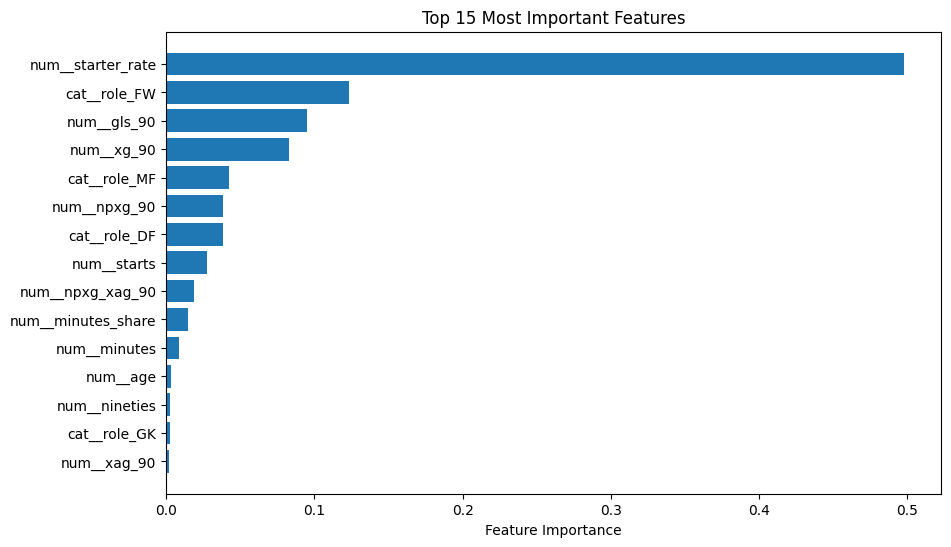

In [57]:
importances = best_pipe.named_steps["model"].feature_importances_
feature_names = pre.get_feature_names_out()
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx][-15:], importances[sorted_idx][-15:])
plt.xlabel("Feature Importance")
plt.title("Top 15 Most Important Features")
plt.show()

# Step 7: Rank all euro players by the predicted performance

In [60]:
df_model["predicted_performance"] = best_pipe.predict(X)

df_ranked = df_model.sort_values(by="predicted_performance", ascending=False)

# Reset index for neatness
df_ranked = df_ranked.reset_index(drop=True)

# Display top 10
df_ranked[["player_name", "role", "predicted_performance"]]

,player_name,role,predicted_performance
0,Ollie Watkins,FW,2.479359
1,Cenk Tosun,FW,1.486857
2,Niclas Füllkrug,FW,1.424100
3,Ivan Schranz,FW,1.178540
4,Jan Mlakar,MF,1.032945
...,...,...,...
479,Bartosz Bereszyński,DF,-2.193907
480,Benjamin Henrichs,DF,-2.195982
481,Kevin Csoboth,DF,-2.426180
482,Saba Lobzhanidze,FW,-3.402711


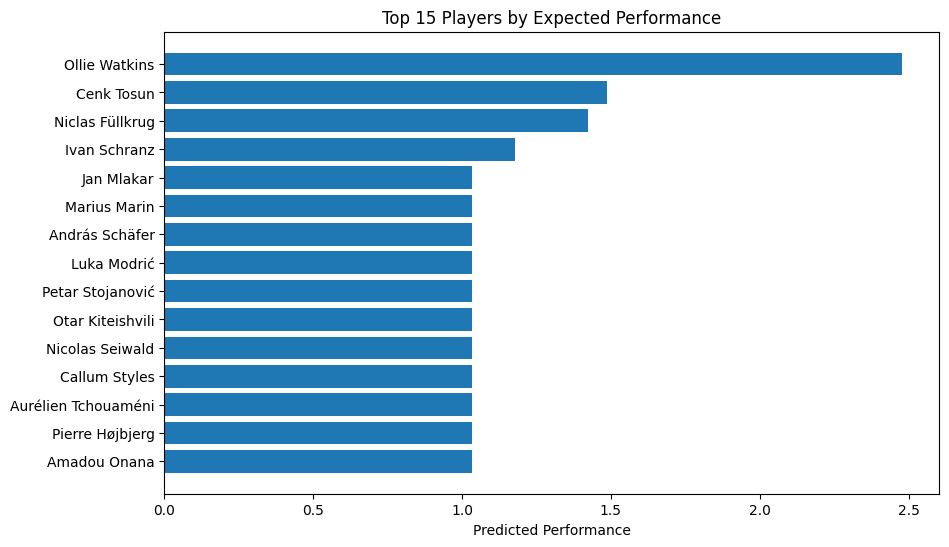

In [62]:
import matplotlib.pyplot as plt

top_n = 15
top_players = df_ranked.head(top_n)

plt.figure(figsize=(10,6))
plt.barh(top_players["player_name"][::-1], top_players["predicted_performance"][::-1])
plt.xlabel("Predicted Performance")
plt.title(f"Top {top_n} Players by Expected Performance")
plt.show()

# Step 8: Match epl players with their predictions

In [71]:
# 1) Fetch EPL player list
fb_epl = FBref(leagues=["ENG-Premier League"], seasons=["2024-2025"])
epl_std = fb_epl.read_player_season_stats(stat_type="standard").reset_index()

# 2) Build a clean name key in both frames (strip accents/case/punct)
def clean_name(s):
    if pd.isna(s): return s
    s = unidecode(str(s)).lower()
    return "".join(ch for ch in s if ch.isalnum() or ch.isspace()).strip()

epl_std["player_key"] = epl_std["player"].map(clean_name)
df_model = df_model.copy()
df_model["player_key"] = df_model["player_name"].map(clean_name)


# 3) Keep only EPL players found
epl_keys = set(epl_std["player_key"].dropna().unique())
df_epl = df_model[df_model["player_key"].isin(epl_keys)].copy()

# 4) Make sure feature columns line up with what the model was trained on
# (X_cols is what you used for training: num_feats + role dummies in that exact order)
role_dummies_full = pd.get_dummies(df_epl["role"], prefix="role")
X_new = pd.concat([df_epl[num_feats].astype(float), role_dummies_full], axis=1)

# align to training columns (any missing dummy gets filled with 0)
X_new = X_new.reindex(columns=X.columns, fill_value=0)

# 5) Predict and rank
df_epl["predicted_performance"] = best_pipe.predict(X_new)
df_epl_ranked = (
    df_epl
      .sort_values("predicted_performance", ascending=False)
      .reset_index(drop=True)
)

# 6) Inspect/save
cols_show = ["player_name", "team_name", "role", "predicted_performance"]
print(df_epl_ranked[cols_show].head(20))
df_epl_ranked[cols_show].to_csv("premier_league_player_rankings.csv", index=False)

[10/15/25 14:05:46] INFO     Saving cached data to /Users/derrick/soccerdata/data/FBref              ]8;id=145797;file:///Users/derrick/DataspellProjects/epl/epl-predictor/backend/epl/lib/python3.11/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=714434;file:///Users/derrick/DataspellProjects/epl/epl-predictor/backend/epl/lib/python3.11/site-packages/soccerdata/_common.py#263\263]8;;\

                    WARNING  /Users/derrick/DataspellProjects/epl/epl-predictor/backend/epl/lib/pyt ]8;id=708513;file:///Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=865768;file:///Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/warnings.py#110\110]8;;\
                             hon3.11/site-packages/soccerdata/fbref.py:165: FutureWarning: The                     
                             behavior of DataFrame concatenation with empty or all-NA entries is                   
                             deprecated. In a future version, this will no longer exclude empty or                 
                             all-NA columns when determining the result dtypes. To retain the old                  
                             behavior, exclude the relevant entries before the concat operation.                   
                               pd.concat(dfs)                                                                      
                                                                                                                   

          player_name    team_name role  predicted_performance
0     Scott McTominay     Scotland   MF               0.360409
1         Bukayo Saka      England   FW               0.351093
2      Bernardo Silva     Portugal   FW               0.345798
3               Rodri        Spain   MF               0.342341
4         Kyle Walker      England   DF               0.270788
5          David Raya        Spain   GK               0.270259
6      Altay Bayındır      Türkiye   GK               0.269396
7     Jordan Pickford      England   GK               0.269308
8         John Stones      England   DF               0.269308
9          Rúben Dias     Portugal   DF               0.268859
10      Manuel Akanji  Switzerland   DF               0.268561
11     William Saliba       France   DF               0.268439
12    Martin Dúbravka     Slovakia   GK               0.268162
13          Wout Faes      Belgium   DF               0.268072
14   Timothy Castagne      Belgium   DF               0

Use a 5-star rating for the players

In [78]:
df = df_epl_ranked.copy()  # has 'predicted_performance'

# Robust scaling anchors
p5, p95 = np.nanpercentile(df["predicted_performance"], [5, 95])
den = (p95 - p5) if (p95 - p5) != 0 else 1.0

# Map to [1, 5], clip, and round to 1 decimal
scaled = (df["predicted_performance"] - p5) / den
rating = 1.0 + 4.0 * scaled
df["rating_5pt"] = np.clip(rating, 1.0, 5.0).round(1)

# Nice, ranked view
cols_show = ["player_name", "team_name", "role", "predicted_performance", "rating_5pt"]
df_out = df.sort_values(["rating_5pt", "predicted_performance"], ascending=[False, False])[cols_show]
print(df_out.head(25))

# Save if you like
df_out.to_csv("premier_league_player_ratings_5pt.csv", index=False)

          player_name    team_name role  predicted_performance  rating_5pt
0     Scott McTominay     Scotland   MF               0.360409         5.0
1         Bukayo Saka      England   FW               0.351093         5.0
2      Bernardo Silva     Portugal   FW               0.345798         5.0
3               Rodri        Spain   MF               0.342341         5.0
4         Kyle Walker      England   DF               0.270788         5.0
5          David Raya        Spain   GK               0.270259         5.0
6      Altay Bayındır      Türkiye   GK               0.269396         5.0
7     Jordan Pickford      England   GK               0.269308         5.0
8         John Stones      England   DF               0.269308         5.0
9          Rúben Dias     Portugal   DF               0.268859         5.0
10      Manuel Akanji  Switzerland   DF               0.268561         5.0
11     William Saliba       France   DF               0.268439         5.0
12    Martin Dúbravka    

In [83]:
# --- 1) Flatten MultiIndex columns from epl_info ---
def flatten_cols(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = [
            "_".join([str(x).strip().lower().replace(" ", "_")
                      for x in tup if x and str(x) != "nan"]).strip("_")
            for tup in df.columns.tolist()
        ]
    else:
        df = df.copy()
        df.columns = [str(c).strip().lower().replace(" ", "_") for c in df.columns]
    return df

epl_flat = flatten_cols(epl_info)

# --- 2) Choose team & age columns robustly ---
team_col = "team" if "team" in epl_flat.columns else ("squad" if "squad" in epl_flat.columns else None)
age_col  = "age"  if "age"  in epl_flat.columns else None

if team_col is None:
    raise ValueError(f"Couldn't find team column in EPL data. Got: {list(epl_flat.columns)[:25]}")
if age_col is None:
    raise ValueError(f"Couldn't find age column in EPL data. Got: {list(epl_flat.columns)[:25]}")

# --- 3) Make a clean join key on both sides ---
def clean_name(s):
    if pd.isna(s):
        return s
    s = str(s).lower().strip()
    s = "".join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))
    s = "".join(ch for ch in s if ch.isalnum() or ch.isspace())
    return s

df = df.copy()
df["player_key"] = df["player_name"].map(clean_name)

epl_join = (
    epl_flat
      .assign(player_key=lambda d: d["player"].map(clean_name))
      [[ "player_key", team_col, age_col ]]
      .dropna(subset=["player_key"])
      .drop_duplicates("player_key")
      .rename(columns={team_col: "team", age_col: "age"})
)

# --- 4) Merge and rate 1.0–5.0 ---
merged = df.merge(epl_join, on="player_key", how="left")

p5, p95 = np.nanpercentile(merged["predicted_performance"], [5, 95])
den = (p95 - p5) if (p95 - p5) != 0 else 1.0
scaled = (merged["predicted_performance"] - p5) / den
merged["rating_5pt"] = np.clip(1.0 + 4.0 * scaled, 1.0, 5.0).round(1)

final_df = (
    merged[["player_name", "age", "team", "role", "predicted_performance", "rating_5pt"]]
      .sort_values(["rating_5pt", "predicted_performance"], ascending=[False, False])
      .reset_index(drop=True)
)

final_df.to_csv("premier_league_player_ratings_final.csv", index=False)
print(final_df.head(15))

KeyError: "['age'] not in index"